In [ ]:
# 데이터 zip파일 압축 풀기

!unzip './drive/MyDrive/CLASS/week11/data/cats_and_dogs.zip' -d '/content'

In [ ]:
!pip install efficientnet_pytorch

In [ ]:
from torchvision.io import read_image
from torch.utils.data import Dataset
import pandas as pd
from torch.utils.data import DataLoader
from PIL import Image

In [ ]:
# 이미지 데이터 불러오는 함수

class CustomImageDataset(Dataset):
  def __init__(self,img_dir,transform=None):
    self.img_labels = pd.read_csv(f'{img_dir}/label.csv')
    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self,idx):
    img_path = f'{self.img_dir}/{self.img_labels.iloc[idx,0]}'
    img = Image.open(img_path).convert('RGB')
    if self.transform:
      img = self.transform(img)
    label = self.img_labels.iloc[idx,1]
    return img,label

In [ ]:
# 데이터 정의

from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms
from torchvision.transforms import RandomCrop, RandomRotation, RandomHorizontalFlip

desired_size = 224

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CustomImageDataset("./cats_and_dogs/train", transform=transform)
test_dataset = CustomImageDataset("./cats_and_dogs/test", transform=transform)

In [ ]:
# 데이터로더 배치 정의

train_dataloader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=32,shuffle=False)

In [ ]:
# 이미지 확인 함수

def plot_batch(batch, label_dict, cmap=None):
    img_tensor_batch = batch[0]
    label_batch = batch[1]
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        img_tensor = img_tensor_batch[i]
        img_array = img_tensor.numpy().transpose(1, 2, 0)
        ax.imshow(img_array, cmap=cmap)
        ax.set_title(f"{label_dict[label_batch[i].item()]}")

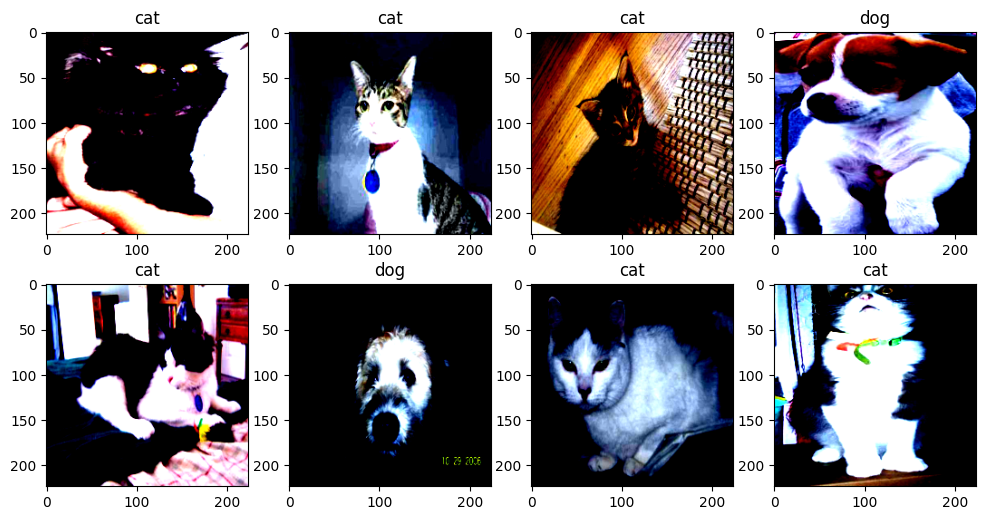

In [ ]:
# 레이블 지정 및 확인

from matplotlib import pyplot as plt

label_dict = {0: "cat", 1: "dog"}
for batch in train_dataloader:
    plot_batch(batch, label_dict)
    break

## 학습 함수 정의

In [ ]:
def get_mean(metrics):
    return round(sum(metrics) / len(metrics), 4)

In [ ]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score


def train_model(model):
    model.train()
    loss_list = []
    acc_list = []
    for x_train, y_train in tqdm(train_dataloader):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = torch.argmax(outputs, dim=1)
        acc = ((y_train == pred).sum() / len(y_train)).item()
        acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [ ]:
def validate_model(model):
    model.eval()
    loss_list = []
    acc_list = []
    for x_val, y_val in tqdm(test_dataloader):
        x_val = x_val.to(device)
        y_val = y_val.to(device)
        with torch.no_grad():
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            loss_list.append(loss.item())

            pred = torch.argmax(outputs, dim=1)
            acc = ((y_val == pred).sum() / len(y_val)).item()
            acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [ ]:
from collections import defaultdict

def train_validate_model(model):
    logs = defaultdict(list)
    for epoch in range(epochs):
        train_loss, train_acc = train_model(model)
        val_loss, val_acc = validate_model(model)
        logs["train_loss"].append(train_loss)
        logs["train_acc"].append(train_acc)
        logs["val_loss"].append(val_loss)
        logs["val_acc"].append(val_acc)
        print(f"epoch {epoch + 1} train - loss: {train_loss} acc: {train_acc} val - loss: {val_loss} acc: {val_acc}")
    return logs

In [ ]:
def plot_logs(logs):
    fig = plt.figure(figsize=(10, 4))

    ax0 = fig.add_subplot(1, 2, 1)
    ax1 = fig.add_subplot(1, 2, 2)
    ax0.plot(logs["train_loss"], label="train")
    ax0.plot(logs["val_loss"], label="val")
    ax0.legend()
    ax0.set_title("loss")

    ax1.plot(logs["train_acc"], label="train")
    ax1.plot(logs["val_acc"], label="val")
    ax1.legend()
    ax1.set_title("accuracy")
    plt.legend()

In [ ]:
# cpu - gpu 변경

from efficientnet_pytorch import EfficientNet
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2).to(device)

# 전체 파라미터 freeze
for param in model.parameters():
    param.requires_grad = False

for param in model._blocks[-2].parameters():
    param.requires_grad = True

# FC 레이어는 교체
model._fc = torch.nn.Linear(in_features=1280, out_features=2).to(device)

model = model.to(device)

Loaded pretrained weights for efficientnet-b0


In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()
epochs = 10

100%|██████████| 63/63 [00:12<00:00,  4.94it/s]


epoch 1 train - loss: 0.1362 acc: 0.9526 val - loss: 0.0465 acc: 0.9836


100%|██████████| 63/63 [00:11<00:00,  5.46it/s]


epoch 2 train - loss: 0.0642 acc: 0.9765 val - loss: 0.0408 acc: 0.9831


100%|██████████| 63/63 [00:11<00:00,  5.63it/s]


epoch 3 train - loss: 0.0451 acc: 0.9844 val - loss: 0.0454 acc: 0.9876


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


epoch 4 train - loss: 0.0388 acc: 0.9859 val - loss: 0.0547 acc: 0.9841


100%|██████████| 63/63 [00:12<00:00,  5.12it/s]


epoch 5 train - loss: 0.0311 acc: 0.9879 val - loss: 0.0383 acc: 0.9851


100%|██████████| 63/63 [00:11<00:00,  5.51it/s]


epoch 6 train - loss: 0.0293 acc: 0.9891 val - loss: 0.0459 acc: 0.9851


100%|██████████| 63/63 [00:10<00:00,  5.82it/s]


epoch 7 train - loss: 0.0249 acc: 0.9921 val - loss: 0.045 acc: 0.9826


100%|██████████| 63/63 [00:11<00:00,  5.60it/s]


epoch 8 train - loss: 0.0229 acc: 0.9925 val - loss: 0.039 acc: 0.9861


100%|██████████| 63/63 [00:11<00:00,  5.38it/s]


epoch 9 train - loss: 0.0214 acc: 0.9922 val - loss: 0.0408 acc: 0.9871


100%|██████████| 63/63 [00:11<00:00,  5.58it/s]


epoch 10 train - loss: 0.0205 acc: 0.9928 val - loss: 0.0409 acc: 0.9856


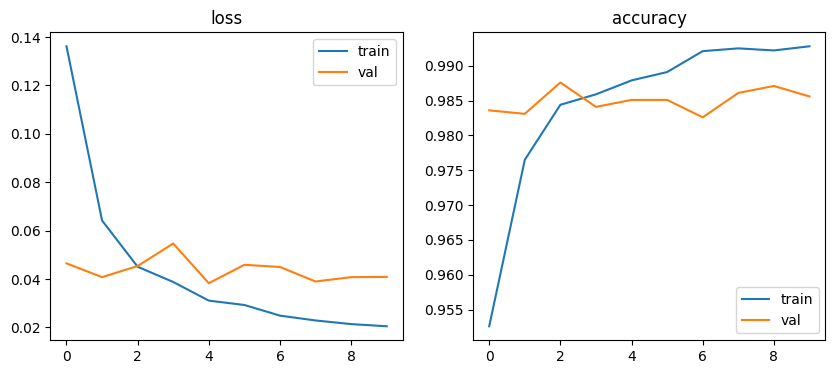

In [ ]:
logs = train_validate_model(model)
plot_logs(logs)